# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binary

In [3]:
import tensorflow as tf
import os

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 116 files belonging to 4 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

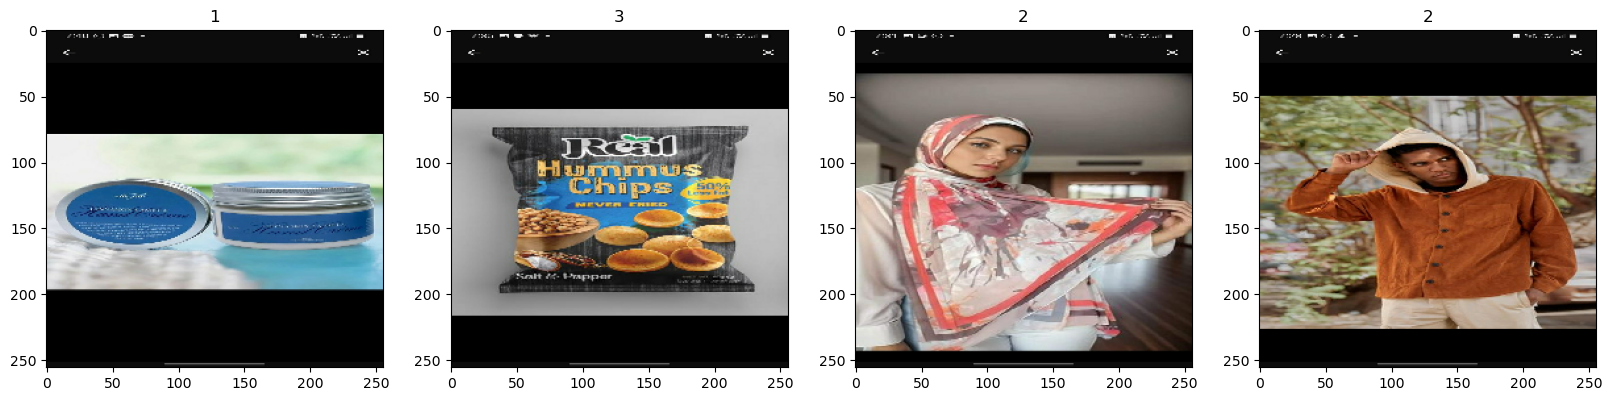

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x, y: (x / 255, tf.one_hot(y, depth=4)))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          ...,
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882]],
 
         [[0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          ...,
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882]],
 
         [[0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          ...,
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882],
          [0.04705882, 0.04705882, 0.04705882]],
 
         ...,
 
         [[0.04705882, 0.04705882, 0.04705882],
          [0.04705

# 5. Split Data

In [15]:
len(data)

4

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [17]:
print(train_size)
print(val_size)
print(test_size)

2
1
1


In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [23]:
model.compile('adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 2.0206 - accuracy: 0.3594 - val_loss: 1.4641 - val_accuracy: 0.4375
Epoch 2/20
2/2 [==============================] - 2s 927ms/step - loss: 1.4534 - accuracy: 0.3906 - val_loss: 1.4642 - val_accuracy: 0.3125
Epoch 3/20
2/2 [==============================] - 2s 924ms/step - loss: 1.3743 - accuracy: 0.3750 - val_loss: 1.1883 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 2s 878ms/step - loss: 1.2227 - accuracy: 0.4375 - val_loss: 1.0654 - val_accuracy: 0.7500
Epoch 5/20
2/2 [==============================] - 2s 863ms/step - loss: 1.1103 - accuracy: 0.6094 - val_loss: 0.9427 - val_accuracy: 0.6250
Epoch 6/20
2/2 [==============================] - 2s 867ms/step - loss: 0.9752 - accuracy: 0.5625 - val_loss: 0.9373 - val_accuracy: 0.6562
Epoch 7/20
2/2 [==============================] - 2s 814ms/step - loss: 0.8369 - accuracy: 0.7188 - val_loss: 0.7009 - val_accuracy: 0.8750
Epoch 8/20
2/2 [=======

# 8. Plot Performance

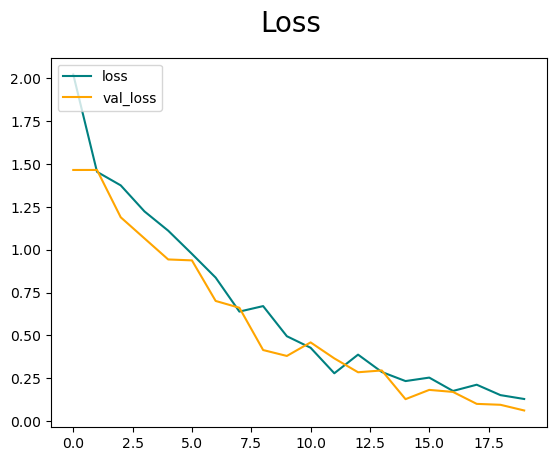

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

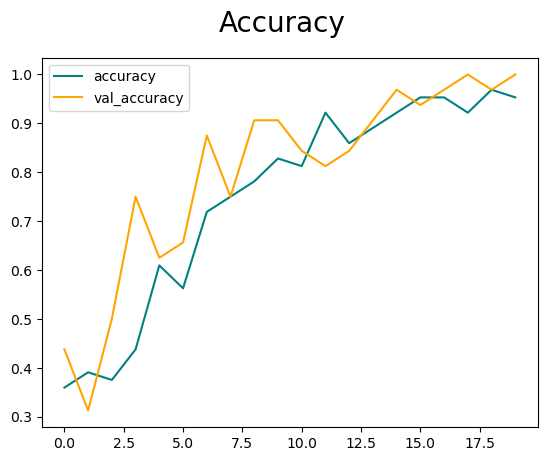

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 128ms/step


In [33]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [34]:
import cv2

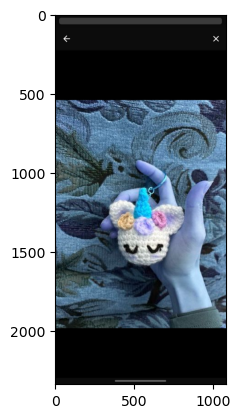

In [42]:
img = cv2.imread('manualtest/atest4.jpg')
plt.imshow(img)
plt.show()

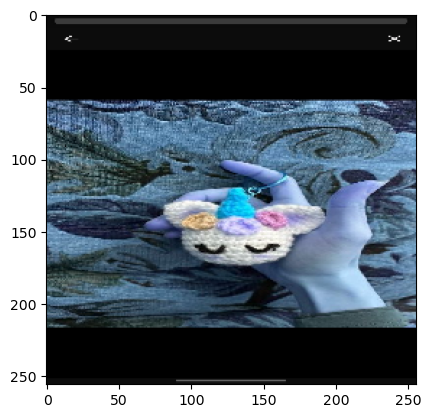

In [43]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [44]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [45]:
yhat

array([[0.8784261 , 0.00312369, 0.0402253 , 0.07822495]], dtype=float32)

In [46]:
predicted_class = np.argmax(yhat)

# Map the predicted class index to the corresponding class label
class_mapping = {0: "accessories", 1: "beauty", 2: "fashion", 3: "nutrition"}
predicted_label = class_mapping[predicted_class]

print("Predicted class:", predicted_label)

Predicted class: accessories
